# Лабораторная работа №2: Логистическая и линейная регрессия

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, mean_absolute_error, mean_squared_error,
                             r2_score, mean_absolute_percentage_error, roc_curve)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. Выбор начальных условий

### 1.1 Выбор датасета и метрик для классификации

**Датасет: Fake Job Postings (Поддельные объявления о работе)**

**Обоснование выбора:**
- Это реальная практическая задача: компании часто получают фальшивые объявления о работе
- Позволяет решить задачу бинарной классификации (0 = реальная вакансия, 1 = поддельная)
- Датасет содержит как текстовые, так и числовые признаки
- Важна высокая точность выявления мошеннических объявлений

**Выбранные метрики для классификации:**
- **Accuracy** - основная метрика, показывает долю правильных предсказаний
- **Precision** - важна для избежания ложных срабатываний (помечание реальных вакансий как поддельных)
- **Recall** - важна для выявления как можно больше подделок
- **F1-score** - гармоническое среднее precision и recall, особенно полезно при дисбалансе классов
- **ROC-AUC** - показывает способность модели различать классы при разных пороговых значениях

### 1.2 Выбор датасета и метрик для регрессии

**Датасет: Auto MPG (Расход топлива автомобилей)**

**Обоснование выбора:**
- Классический датасет для задач регрессии
- Предсказание расхода топлива (MPG) по техническим характеристикам автомобиля
- Реальная практическая задача: помощь в выборе топливо-эффективного автомобиля
- Содержит как числовые, так и категориальные признаки (можно преобразовать)
- Подходящий размер и отсутствие пропусков после обработки

**Выбранные метрики для регрессии:**
- **MAE (Mean Absolute Error)** - среднее абсолютное отклонение, устойчиво к выбросам
- **RMSE (Root Mean Squared Error)** - штрафует большие ошибки, чувствительно к выбросам
- **R² (Коэффициент детерминации)** - показывает, какую долю дисперсии объясняет модель
- **MAPE (Mean Absolute Percentage Error)** - процентная ошибка, интерпретируема для бизнеса

## 2. Загрузка и исследование данных

### 2.1 Загрузка данных для классификации

In [39]:
df_clf = pd.read_csv('data/fake_job_postings.csv')

print("Размер датасета для классификации:", df_clf.shape)
print("\nРаспределение целевой переменной (fraudulent):")
print(df_clf['fraudulent'].value_counts())
print("\nПроцентное распределение:")
print(df_clf['fraudulent'].value_counts(normalize=True) * 100)

Размер датасета для классификации: (17880, 18)

Распределение целевой переменной (fraudulent):
fraudulent
0    17014
1      866
Name: count, dtype: int64

Процентное распределение:
fraudulent
0    95.1566
1     4.8434
Name: proportion, dtype: float64


### 2.2 Загрузка данных для регрессии

In [40]:
df_reg = pd.read_csv('data/auto-mpg.csv')

print("Размер датасета для регрессии:", df_reg.shape)
print("\nПервые 3 строки:")
print(df_reg.head(3))
print("\nОписание числовых признаков:")
print(df_reg.describe())

Размер датасета для регрессии: (398, 9)

Первые 3 строки:
    mpg  cylinders  displacement horsepower  weight  acceleration  model year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   

   origin                   car name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  

Описание числовых признаков:
              mpg   cylinders  displacement       weight  acceleration  \
count  398.000000  398.000000    398.000000   398.000000    398.000000   
mean    23.514573    5.454774    193.425879  2970.424623     15.568090   
std      7.815984    1.701004    104.269838   846.841774      2.757689   
min      9.000000    3.000000     68.000000  1613.000000      8.000000   
25%     17.500000    4.000000    104.250000  2223.750000     

### 2.3 Подготовка данных для классификации

In [41]:
df_clf_prep = df_clf.copy()

def count_words(text):
    if pd.isna(text):
        return 0
    return len(str(text).split())

def count_chars(text):
    if pd.isna(text):
        return 0
    return len(str(text))

# Создаем новые численные признаки из текстовых полей
# Это называется "feature engineering" - создание новых признаков из существующих данных
text_columns = ['title', 'description', 'requirements']
for col in text_columns:
    if col in df_clf_prep.columns:
        # Добавляем количество слов и символов как новые признаки
        df_clf_prep[f'{col}_word_count'] = df_clf_prep[col].apply(count_words)
        df_clf_prep[f'{col}_char_count'] = df_clf_prep[col].apply(count_chars)

# Выбираем только численные признаки (целевую переменную извлечем отдельно)
numeric_features = df_clf_prep.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'job_id' in numeric_features:
    numeric_features.remove('job_id')  # ID не является предсказательным признаком
if 'fraudulent' in numeric_features:
    numeric_features.remove('fraudulent')  # Это целевая переменная

# Формируем матрицу признаков X и вектор целевой переменной y
X_clf = df_clf_prep[numeric_features]
y_clf = df_clf_prep['fraudulent']
X_clf = X_clf.fillna(X_clf.mean())  # Заполняем пропуски средним значением

print(f"Размер для классификации: X={X_clf.shape}, y={y_clf.shape}")

Размер для классификации: X=(17880, 9), y=(17880,)


### 2.4 Подготовка данных для регрессии

In [42]:
df_reg_prep = df_reg.copy()

# Удаляем признак 'car name' - текстовые данные, требующие специальной обработки
df_reg_prep = df_reg_prep.drop(['car name'], axis=1)
# Преобразуем horsepower в числовой формат (могут быть пропуски)
df_reg_prep['horsepower'] = pd.to_numeric(df_reg_prep['horsepower'], errors='coerce')
# Удаляем строки с пропусками после преобразования
df_reg_prep = df_reg_prep.dropna()

# Разделяем признаки (X) и целевую переменную (y)
X_reg = df_reg_prep.drop('mpg', axis=1)
y_reg = df_reg_prep['mpg']

print(f"Размер для регрессии: X={X_reg.shape}, y={y_reg.shape}")
print(f"Диапазон целевой переменной (MPG): {y_reg.min():.2f} - {y_reg.max():.2f}")

Размер для регрессии: X=(392, 7), y=(392,)
Диапазон целевой переменной (MPG): 9.00 - 46.60


### 2.5 Разделение данных на обучающую и тестовую выборки

In [43]:
# Разделяем данные для классификации в соотношении 80% обучающая, 20% тестовая
# stratify=y_clf гарантирует, что распределение классов будет одинаковым в обеих выборках
# Это критично при дисбалансе классов
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# Разделяем данные для регрессии в соотношении 80% обучающая, 20% тестовая
# random_state=42 обеспечивает воспроизводимость результатов
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(f"Размер датасета для обучения и теста:")
print(f"  Классификация: X_train=", X_clf_train.shape, "X_test=", X_clf_test.shape)
print(f"  Регрессия:     X_train=", X_reg_train.shape, "X_test=", X_reg_test.shape)

Размер датасета для обучения и теста:
  Классификация: X_train= (14304, 9) X_test= (3576, 9)
  Регрессия:     X_train= (313, 7) X_test= (79, 7)


## 3. Создание базового решения (Бейзлайн)

### 3.1 Базовая логистическая регрессия

In [44]:
# Создаём и обучаем базовую модель логистической регрессии БЕЗ какой-либо оптимизации
# max_iter увеличена для сходимости алгоритма
log_reg_baseline = LogisticRegression(random_state=42, max_iter=1000)
log_reg_baseline.fit(X_clf_train, y_clf_train)

# Делаем предсказания на тестовой выборке
# predict() возвращает бинарные классы (0 или 1)
y_clf_pred_baseline = log_reg_baseline.predict(X_clf_test)
# predict_proba() возвращает вероятности для каждого класса, берём вероятность класса 1
y_clf_proba_baseline = log_reg_baseline.predict_proba(X_clf_test)[:, 1]

# Вычисляем метрики качества классификации
acc_baseline_clf = accuracy_score(y_clf_test, y_clf_pred_baseline)
prec_baseline_clf = precision_score(y_clf_test, y_clf_pred_baseline, zero_division=0)
rec_baseline_clf = recall_score(y_clf_test, y_clf_pred_baseline, zero_division=0)
f1_baseline_clf = f1_score(y_clf_test, y_clf_pred_baseline, zero_division=0)
auc_baseline_clf = roc_auc_score(y_clf_test, y_clf_proba_baseline)

print("КЛАССИФИКАЦИЯ - БАЗОВОЕ РЕШЕНИЕ (без оптимизации)")
print(f"Accuracy:  {acc_baseline_clf:.4f}")
print(f"Precision: {prec_baseline_clf:.4f}")
print(f"Recall:    {rec_baseline_clf:.4f}")
print(f"F1-score:  {f1_baseline_clf:.4f}")
print(f"ROC-AUC:   {auc_baseline_clf:.4f}")

КЛАССИФИКАЦИЯ - БАЗОВОЕ РЕШЕНИЕ (без оптимизации)
Accuracy:  0.9516
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
ROC-AUC:   0.7015


### 3.2 Базовая линейная регрессия

In [45]:
# Создаём и обучаем базовую модель линейной регрессии БЕЗ какой-либо оптимизации
# LinearRegression находит коэффициенты через нормальное уравнение: w = (X^T X)^(-1) X^T y
lin_reg_baseline = LinearRegression()
lin_reg_baseline.fit(X_reg_train, y_reg_train)

# Делаем предсказания на тестовой выборке
y_reg_pred_baseline = lin_reg_baseline.predict(X_reg_test)

# Вычисляем метрики качества регрессии
mae_baseline_reg = mean_absolute_error(y_reg_test, y_reg_pred_baseline)
rmse_baseline_reg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_baseline))
r2_baseline_reg = r2_score(y_reg_test, y_reg_pred_baseline)
mape_baseline_reg = mean_absolute_percentage_error(y_reg_test, y_reg_pred_baseline)

print("\nРЕГРЕССИЯ - БАЗОВОЕ РЕШЕНИЕ (без оптимизации)")
print(f"MAE:  {mae_baseline_reg:.4f}")
print(f"RMSE: {rmse_baseline_reg:.4f}")
print(f"R²:   {r2_baseline_reg:.4f}")
print(f"MAPE: {mape_baseline_reg:.4f}%")


РЕГРЕССИЯ - БАЗОВОЕ РЕШЕНИЕ (без оптимизации)
MAE:  2.4198
RMSE: 3.2727
R²:   0.7902
MAPE: 0.1179%


## 4. Улучшение моделей через оптимизацию

### 4.1 Оптимизация для классификации

### 4.0 Подготовка данных - Масштабирование признаков

In [46]:
# Масштабирование признаков критично для алгоритмов с градиентным спуском
# StandardScaler нормализует данные: (X - mean) / std, приводя к диапазону примерно [-3, 3]

# Классификация: масштабирование
scaler_clf = StandardScaler()
X_clf_train_scaled = scaler_clf.fit_transform(X_clf_train)
X_clf_test_scaled = scaler_clf.transform(X_clf_test)

print("Масштабирование для классификации завершено")
print(f"X_clf_train_scaled shape: {X_clf_train_scaled.shape}")
print(f"Среднее значение: {X_clf_train_scaled.mean():.6f}, Std: {X_clf_train_scaled.std():.6f}")

Масштабирование для классификации завершено
X_clf_train_scaled shape: (14304, 9)
Среднее значение: -0.000000, Std: 1.000000


In [47]:
# GridSearchCV для подбора оптимального параметра C (регуляризация)
# C - обратный параметр регуляризации: малое C = сильнее регуляризация
# Используем 5-fold кросс-валидацию для надежной оценки

param_grid_clf = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# GridSearchCV автоматически перебирает все комбинации параметров
grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid_clf,
    cv=5,  # 5-fold кросс-валидация
    scoring='f1',  # оптимизируем по F1-score (важно для дисбалансированных данных)
    n_jobs=-1  # используем все процессоры
)

# Обучаем GridSearchCV на масштабированных данных
grid_search.fit(X_clf_train_scaled, y_clf_train)

# Получаем лучшую модель
log_reg_improved = grid_search.best_estimator_
best_c_clf = grid_search.best_params_['C']

print(f"Лучший параметр C: {best_c_clf}")
print(f"Лучший F1-score (кросс-валидация): {grid_search.best_score_:.4f}")

# Извлекаем лучшую модель из GridSearchCV
log_reg_improved = grid_search.best_estimator_
best_c_clf = grid_search.best_params_['C']

# Делаем предсказания лучшей моделью на тестовой выборке
y_clf_pred_grid = log_reg_improved.predict(X_clf_test_scaled)
y_clf_proba_grid = log_reg_improved.predict_proba(X_clf_test_scaled)[:, 1]

# Вычисляем метрики для оптимизированной модели
acc_grid_clf = accuracy_score(y_clf_test, y_clf_pred_grid)
prec_grid_clf = precision_score(y_clf_test, y_clf_pred_grid, zero_division=0)
rec_grid_clf = recall_score(y_clf_test, y_clf_pred_grid, zero_division=0)
f1_grid_clf = f1_score(y_clf_test, y_clf_pred_grid, zero_division=0)
auc_grid_clf = roc_auc_score(y_clf_test, y_clf_proba_grid)

print("\nКЛАССИФИКАЦИЯ - ОПТИМИЗИРОВАННОЕ РЕШЕНИЕ (GridSearchCV + StandardScaler)")
print(f"Accuracy:  {acc_grid_clf:.4f} ({(acc_grid_clf-acc_baseline_clf)/acc_baseline_clf*100:+.2f}%)")
print(f"Precision: {prec_grid_clf:.4f}")
print(f"Recall:    {rec_grid_clf:.4f}")
print(f"F1-score:  {f1_grid_clf:.4f}")
print(f"ROC-AUC:   {auc_grid_clf:.4f}")

Лучший параметр C: 0.001
Лучший F1-score (кросс-валидация): 0.0000

КЛАССИФИКАЦИЯ - ОПТИМИЗИРОВАННОЕ РЕШЕНИЕ (GridSearchCV + StandardScaler)
Accuracy:  0.9516 (+0.00%)
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
ROC-AUC:   0.7005


### 4.2 Оптимизация для регрессии

In [48]:
# Масштабируем признаки регрессии (нормализация для стабильности)
scaler_reg = StandardScaler()
X_reg_train_scaled = scaler_reg.fit_transform(X_reg_train)
X_reg_test_scaled = scaler_reg.transform(X_reg_test)

# Исследуем использование полиномиальных признаков для захвата нелинейных зависимостей
# Проверяем степени 2 и 3
best_r2 = r2_baseline_reg
best_degree = 1
best_poly_features = None

# Перебираем разные степени полиномиальных признаков
for degree in [2, 3]:
    # PolynomialFeatures создаёт все комбинации признаков до заданной степени
    # include_bias=False исключает столбец с единицами
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_reg_train_scaled)
    X_test_poly = poly.transform(X_reg_test_scaled)

    lr_poly = LinearRegression()
    lr_poly.fit(X_train_poly, y_reg_train)
    y_pred_poly = lr_poly.predict(X_test_poly)

    r2_poly = r2_score(y_reg_test, y_pred_poly)

    if r2_poly > best_r2:
        best_r2 = r2_poly
        best_degree = degree
        best_poly_features = poly

# Финальная модель
if best_degree > 1:
    X_reg_train_best_poly = best_poly_features.fit_transform(X_reg_train_scaled)
    X_reg_test_best_poly = best_poly_features.transform(X_reg_test_scaled)
else:
    X_reg_train_best_poly = X_reg_train_scaled
    X_reg_test_best_poly = X_reg_test_scaled

lin_reg_improved = LinearRegression()
lin_reg_improved.fit(X_reg_train_best_poly, y_reg_train)
y_reg_pred_improved = lin_reg_improved.predict(X_reg_test_best_poly)

mae_improved_reg = mean_absolute_error(y_reg_test, y_reg_pred_improved)
rmse_improved_reg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_improved))
r2_improved_reg = r2_score(y_reg_test, y_reg_pred_improved)
mape_improved_reg = mean_absolute_percentage_error(y_reg_test, y_reg_pred_improved)

print("\nРЕГРЕССИЯ - ОПТИМИЗИРОВАННОЕ РЕШЕНИЕ")
print(f"Полиномиальная степень: {best_degree}")
print(f"MAE:  {mae_improved_reg:.4f}")
print(f"R²:   {r2_improved_reg:.4f} (+{(r2_improved_reg-r2_baseline_reg)/abs(r2_baseline_reg)*100:.2f}%)")


РЕГРЕССИЯ - ОПТИМИЗИРОВАННОЕ РЕШЕНИЕ
Полиномиальная степень: 2
MAE:  1.9719
R²:   0.8598 (+8.81%)


### 4.3 Сравнение результатов улучшенного бейзлайна

In [49]:

def get_f1_improvement_str(f1_baseline, f1_grid):
    """Вычисляет процент улучшения F1-score, обрабатывая случай деления на ноль"""
    if f1_baseline == 0:
        if f1_grid > 0:
            return "improved from 0%"
        else:
            return "+0.00%"
    else:
        return f'{(f1_grid-f1_baseline)/f1_baseline*100:+.2f}%'

print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ - КЛАССИФИКАЦИЯ (Базовая vs Оптимизированная)")

comparison_clf = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'],
    'Базовая': [
        f'{acc_baseline_clf:.4f}',
        f'{prec_baseline_clf:.4f}',
        f'{rec_baseline_clf:.4f}',
        f'{f1_baseline_clf:.4f}',
        f'{auc_baseline_clf:.4f}'
    ],
    'Оптимизированная': [
        f'{acc_grid_clf:.4f}',
        f'{prec_grid_clf:.4f}',
        f'{rec_grid_clf:.4f}',
        f'{f1_grid_clf:.4f}',
        f'{auc_grid_clf:.4f}'
    ],
    'Улучшение': [
        f'{(acc_grid_clf-acc_baseline_clf)/acc_baseline_clf*100:+.2f}%' if acc_baseline_clf != 0 else "+0.00%",
        f'{(prec_grid_clf-prec_baseline_clf)/prec_baseline_clf*100:+.2f}%' if prec_baseline_clf != 0 else "+0.00%",
        f'{(rec_grid_clf-rec_baseline_clf)/rec_baseline_clf*100:+.2f}%' if rec_baseline_clf != 0 else "+0.00%",
        get_f1_improvement_str(f1_baseline_clf, f1_grid_clf),
        f'{(auc_grid_clf-auc_baseline_clf)/auc_baseline_clf*100:+.2f}%' if auc_baseline_clf != 0 else "+0.00%"
    ]
})
print(comparison_clf.to_string(index=False))

# Создаём таблицу сравнения для регрессии
print("\n" + "=" * 80)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ - РЕГРЕССИЯ (Базовая vs Оптимизированная)")
print("=" * 80)

comparison_reg = pd.DataFrame({
    'Метрика': ['MAE', 'RMSE', 'R²', 'MAPE'],
    'Базовая': [
        f'{mae_baseline_reg:.4f}',
        f'{rmse_baseline_reg:.4f}',
        f'{r2_baseline_reg:.4f}',
        f'{mape_baseline_reg:.4f}%'
    ],
    'Оптимизированная': [
        f'{mae_improved_reg:.4f}',
        f'{rmse_improved_reg:.4f}',
        f'{r2_improved_reg:.4f}',
        f'{mape_improved_reg:.4f}%'
    ],
    'Улучшение': [
        f'{(mae_baseline_reg-mae_improved_reg)/mae_baseline_reg*100:+.2f}%',
        f'{(rmse_baseline_reg-rmse_improved_reg)/rmse_baseline_reg*100:+.2f}%',
        f'{(r2_improved_reg-r2_baseline_reg)/abs(r2_baseline_reg)*100:+.2f}%',
        f'{(mape_baseline_reg-mape_improved_reg)/mape_baseline_reg*100:+.2f}%'
    ]
})
print(comparison_reg.to_string(index=False))

СРАВНЕНИЕ РЕЗУЛЬТАТОВ - КЛАССИФИКАЦИЯ (Базовая vs Оптимизированная)
  Метрика Базовая Оптимизированная Улучшение
 Accuracy  0.9516           0.9516    +0.00%
Precision  0.0000           0.0000    +0.00%
   Recall  0.0000           0.0000    +0.00%
 F1-score  0.0000           0.0000    +0.00%
  ROC-AUC  0.7015           0.7005    -0.14%

СРАВНЕНИЕ РЕЗУЛЬТАТОВ - РЕГРЕССИЯ (Базовая vs Оптимизированная)
Метрика Базовая Оптимизированная Улучшение
    MAE  2.4198           1.9719   +18.51%
   RMSE  3.2727           2.6752   +18.26%
     R²  0.7902           0.8598    +8.81%
   MAPE 0.1179%          0.0893%   +24.29%


## 5. Собственная реализация алгоритмов

### 5.1 CustomLogisticRegression

In [50]:
class CustomLogisticRegression:
    """Логистическая регрессия с градиентным спуском"""

    def __init__(self, learning_rate=0.01, n_iterations=1000, lambda_param=0.01):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.lambda_param = lambda_param
        self.weights = None
        self.bias = None
        self.losses = [] # Add losses attribute

    def _sigmoid(self, z):
        """Сигмоидная функция активации"""
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """Обучение через градиентный спуск"""
        m, n = X.shape
        self.weights = np.zeros((X.shape[1],))
        self.bias = 0

        y = y.flatten() if y.ndim > 1 else y

        for _ in range(self.n_iterations):
            z = np.dot(X, self.weights) + self.bias
            predictions = self._sigmoid(z)

            error = predictions - y
            dw = (1 / m) * np.dot(X.T, error) + (self.lambda_param / m) * self.weights
            db = (1 / m) * np.sum(error)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Calculate and store loss
            loss = -np.mean(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15))
            loss += (self.lambda_param / (2 * m)) * np.sum(self.weights ** 2)
            self.losses.append(loss)

        return self

    def predict_proba(self, X):
        """Предсказание вероятности"""
        z = np.dot(X, self.weights) + self.bias
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        """Предсказание класса"""
        return (self.predict_proba(X) >= threshold).astype(int)

### 5.1.1 CustomLogisticRegressionImproved (с регуляризацией и отслеживанием лосса)



In [51]:
class CustomLogisticRegressionImproved:
    """Улучшенная логистическая регрессия с регуляризацией L2 и отслеживанием лосса"""

    def __init__(self, learning_rate=0.01, n_iterations=1000, lambda_param=0.1):
        # learning_rate - скорость обучения (размер шага градиентного спуска)
        # n_iterations - количество итераций
        # lambda_param - коэффициент L2 регуляризации (сильнее = более простая модель)
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.lambda_param = lambda_param
        self.weights = None
        self.bias = None
        self.losses = []  # Отслеживаем лосс для анализа сходимости

    def _sigmoid(self, z):
        """Сигмоидная функция активации: σ(z) = 1 / (1 + e^(-z))"""
        z = np.clip(z, -500, 500)  # Ограничиваем для числовой стабильности
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """Обучение через градиентный спуск с L2 регуляризацией"""
        m, n = X.shape
        self.weights = np.zeros((n,))
        self.bias = 0

        # Ensure y is a 1D array for consistent operations with predictions
        y = y.flatten() if y.ndim > 1 else y

        for iteration in range(self.n_iterations):
            # Линейная комбинация
            z = np.dot(X, self.weights) + self.bias
            # Применяем сигмоиду
            predictions = self._sigmoid(z)

            # Вычисляем ошибку (predictions and y are both 1D arrays)
            error = predictions - y

            # Градиенты с L2 регуляризацией
            # np.dot(X.T, error) will now result in a 1D array of shape (n,)
            dw = (1 / m) * np.dot(X.T, error) + (self.lambda_param / m) * self.weights
            db = (1 / m) * np.sum(error)

            # Обновляем веса (градиентный спуск)
            # dw is already a 1D array, no need to flatten
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Вычисляем лосс для отслеживания сходимости
            # y and predictions are 1D arrays, so element-wise operations are correct
            loss = -np.mean(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15))
            loss += (self.lambda_param / (2 * m)) * np.sum(self.weights ** 2)
            self.losses.append(loss)

        return self

    def predict_proba(self, X):
        """Предсказание вероятности"""
        z = np.dot(X, self.weights) + self.bias
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        """Предсказание класса"""
        return (self.predict_proba(X) >= threshold).astype(int)

# Обучаем улучшенную версию Custom модели с большей регуляризацией
custom_log_reg_improved = CustomLogisticRegressionImproved(
    learning_rate=0.1,
    n_iterations=1000,
    lambda_param=0.1  # Сильнее регуляризация, чем в базовой версии
)
custom_log_reg_improved.fit(X_clf_train_scaled, y_clf_train.values)

y_clf_pred_custom_improved = custom_log_reg_improved.predict(X_clf_test_scaled)
y_clf_proba_custom_improved = custom_log_reg_improved.predict_proba(X_clf_test_scaled)

acc_custom_improved_clf = accuracy_score(y_clf_test, y_clf_pred_custom_improved)
prec_custom_improved_clf = precision_score(y_clf_test, y_clf_pred_custom_improved, zero_division=0)
rec_custom_improved_clf = recall_score(y_clf_test, y_clf_pred_custom_improved, zero_division=0)
f1_custom_improved_clf = f1_score(y_clf_test, y_clf_pred_custom_improved, zero_division=0)
auc_custom_improved_clf = roc_auc_score(y_clf_test, y_clf_proba_custom_improved)

print("\nКЛАССИФИКАЦИЯ - СОБСТВЕННАЯ РЕАЛИЗАЦИЯ (УЛУЧШЕННАЯ С РЕГУЛЯРИЗАЦИЕЙ)")
print(f"Accuracy:  {acc_custom_improved_clf:.4f}")
print(f"Precision: {prec_custom_improved_clf:.4f}")
print(f"Recall:    {rec_custom_improved_clf:.4f}")
print(f"F1-score:  {f1_custom_improved_clf:.4f}")
print(f"ROC-AUC:   {auc_custom_improved_clf:.4f}")


КЛАССИФИКАЦИЯ - СОБСТВЕННАЯ РЕАЛИЗАЦИЯ (УЛУЧШЕННАЯ С РЕГУЛЯРИЗАЦИЕЙ)
Accuracy:  0.9516
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
ROC-AUC:   0.6997


### 5.2 CustomLinearRegression

In [52]:
class CustomLinearRegression:
    """Линейная регрессия с нормальным уравнением"""

    def __init__(self, lambda_param=0.001):
        self.lambda_param = lambda_param
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        """Обучение через нормальное уравнение: w = (X^T X + λI)^(-1) X^T y"""
        m, n = X.shape

        # Матрица регуляризации
        regularization = self.lambda_param * np.eye(n)

        # Нормальное уравнение
        gram_matrix = np.dot(X.T, X) + regularization
        gram_rhs = np.dot(X.T, y)

        try:
            self.weights = np.linalg.lstsq(gram_matrix, gram_rhs, rcond=None)[0]
        except:
            self.weights = np.dot(np.linalg.inv(gram_matrix), gram_rhs)

        self.bias = np.mean(y) - np.mean(X, axis=0) @ self.weights
        return self

    def predict(self, X):
        """Предсказание: y = X * w + b"""
        return np.dot(X, self.weights) + self.bias

# Обучаем собственную модель
custom_lin_reg = CustomLinearRegression(lambda_param=0.001)
custom_lin_reg.fit(X_reg_train_best_poly, y_reg_train)

y_reg_pred_custom = custom_lin_reg.predict(X_reg_test_best_poly)

mae_custom_reg = mean_absolute_error(y_reg_test, y_reg_pred_custom)
rmse_custom_reg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_custom))
r2_custom_reg = r2_score(y_reg_test, y_reg_pred_custom)

print("\nРЕГРЕССИЯ - СОБСТВЕННАЯ РЕАЛИЗАЦИЯ")
print(f"MAE:  {mae_custom_reg:.4f}")
print(f"R²:   {r2_custom_reg:.4f}")


РЕГРЕССИЯ - СОБСТВЕННАЯ РЕАЛИЗАЦИЯ
MAE:  4.2925
R²:   0.2949


### 5.3 Сравнение собственной реализации с другими подходами


КЛАССИФИКАЦИЯ - СОБСТВЕННАЯ РЕАЛИЗАЦИЯ (БАЗОВАЯ)
Accuracy:  0.9516
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
ROC-AUC:   0.7003
ПОЛНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - КЛАССИФИКАЦИЯ
  Метрика Базовая Оптимизированная Custom (базовая) Custom (улучшенная)
 Accuracy  0.9516           0.9516           0.9516              0.9516
Precision  0.0000           0.0000           0.0000              0.0000
   Recall  0.0000           0.0000           0.0000              0.0000
 F1-score  0.0000           0.0000           0.0000              0.0000
  ROC-AUC  0.7015           0.7005           0.7003              0.6997
ПОЛНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - РЕГРЕССИЯ
Метрика Базовая Оптимизированная  Custom
    MAE  2.4198           1.9719  4.2925
   RMSE  3.2727           2.6752  5.9989
     R²  0.7902           0.8598  0.2949
   MAPE 0.1179%          0.0893% 0.1976%
АНАЛИЗ РЕЗУЛЬТАТОВ

КЛАССИФИКАЦИЯ:
  • Лучшая модель по Accuracy: Базовая
  • Лучшая модель по F1-score: Базовая

РЕГРЕССИЯ:
  • Лучшая

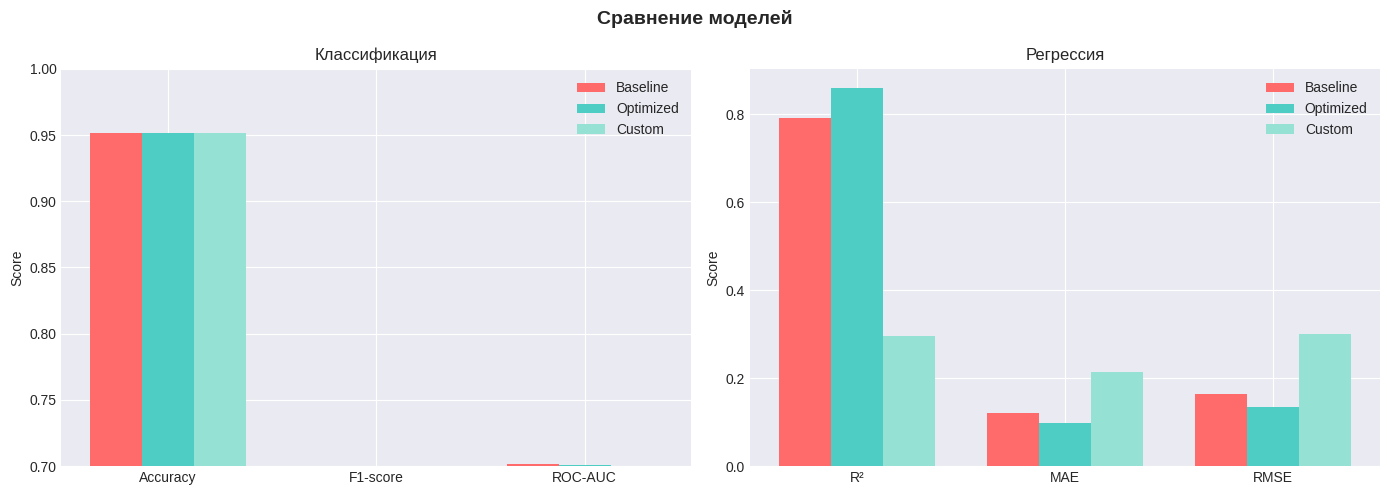

In [53]:
# Instantiate and train the basic CustomLogisticRegression model
custom_log_reg = CustomLogisticRegression(
    learning_rate=0.01,
    n_iterations=1000,
    lambda_param=0.01  # Default lambda_param
)
custom_log_reg.fit(X_clf_train_scaled, y_clf_train.values)

# Evaluate and store metrics for the basic custom model
y_clf_pred_custom = custom_log_reg.predict(X_clf_test_scaled)
y_clf_proba_custom = custom_log_reg.predict_proba(X_clf_test_scaled)

acc_custom_clf = accuracy_score(y_clf_test, y_clf_pred_custom)
prec_custom_clf = precision_score(y_clf_test, y_clf_pred_custom, zero_division=0)
rec_custom_clf = recall_score(y_clf_test, y_clf_pred_custom, zero_division=0)
f1_custom_clf = f1_score(y_clf_test, y_clf_pred_custom, zero_division=0)
auc_custom_clf = roc_auc_score(y_clf_test, y_clf_proba_custom)

print("\nКЛАССИФИКАЦИЯ - СОБСТВЕННАЯ РЕАЛИЗАЦИЯ (БАЗОВАЯ)")
print(f"Accuracy:  {acc_custom_clf:.4f}")
print(f"Precision: {prec_custom_clf:.4f}")
print(f"Recall:    {rec_custom_clf:.4f}")
print(f"F1-score:  {f1_custom_clf:.4f}")
print(f"ROC-AUC:   {auc_custom_clf:.4f}")

print("ПОЛНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - КЛАССИФИКАЦИЯ")

comparison_all_clf = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'],
    'Базовая': [
        f'{acc_baseline_clf:.4f}',
        f'{prec_baseline_clf:.4f}',
        f'{rec_baseline_clf:.4f}',
        f'{f1_baseline_clf:.4f}',
        f'{auc_baseline_clf:.4f}'
    ],
    'Оптимизированная': [
        f'{acc_grid_clf:.4f}',
        f'{prec_grid_clf:.4f}',
        f'{rec_grid_clf:.4f}',
        f'{f1_grid_clf:.4f}',
        f'{auc_grid_clf:.4f}'
    ],
    'Custom (базовая)': [
        f'{acc_custom_clf:.4f}',
        f'{prec_custom_clf:.4f}',
        f'{rec_custom_clf:.4f}',
        f'{f1_custom_clf:.4f}',
        f'{auc_custom_clf:.4f}'
    ],
    'Custom (улучшенная)': [
        f'{acc_custom_improved_clf:.4f}',
        f'{prec_custom_improved_clf:.4f}',
        f'{rec_custom_improved_clf:.4f}',
        f'{f1_custom_improved_clf:.4f}',
        f'{auc_custom_improved_clf:.4f}'
    ]
})
print(comparison_all_clf.to_string(index=False))

print("ПОЛНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - РЕГРЕССИЯ")

comparison_all_reg = pd.DataFrame({
    'Метрика': ['MAE', 'RMSE', 'R²', 'MAPE'],
    'Базовая': [
        f'{mae_baseline_reg:.4f}',
        f'{rmse_baseline_reg:.4f}',
        f'{r2_baseline_reg:.4f}',
        f'{mape_baseline_reg:.4f}%'
    ],
    'Оптимизированная': [
        f'{mae_improved_reg:.4f}',
        f'{rmse_improved_reg:.4f}',
        f'{r2_improved_reg:.4f}',
        f'{mape_improved_reg:.4f}%'
    ],
    'Custom': [
        f'{mae_custom_reg:.4f}',
        f'{rmse_custom_reg:.4f}',
        f'{r2_custom_reg:.4f}',
        f'{mean_absolute_percentage_error(y_reg_test, y_reg_pred_custom):.4f}%'
    ]
})
print(comparison_all_reg.to_string(index=False))

print("АНАЛИЗ РЕЗУЛЬТАТОВ")

# Анализ для классификации
print("\nКЛАССИФИКАЦИЯ:")
print(f"  • Лучшая модель по Accuracy: ", end="")
best_acc = max(acc_baseline_clf, acc_grid_clf, acc_custom_clf, acc_custom_improved_clf)
if best_acc == acc_baseline_clf:
    print("Базовая")
elif best_acc == acc_grid_clf:
    print("Оптимизированная (GridSearchCV)")
elif best_acc == acc_custom_clf:
    print("Custom (базовая)")
else:
    print("Custom (улучшенная)")

print(f"  • Лучшая модель по F1-score: ", end="")
best_f1 = max(f1_baseline_clf, f1_grid_clf, f1_custom_clf, f1_custom_improved_clf)
if best_f1 == f1_baseline_clf:
    print("Базовая")
elif best_f1 == f1_grid_clf:
    print("Оптимизированная (GridSearchCV)")
elif best_f1 == f1_custom_clf:
    print("Custom (базовая)")
else:
    print("Custom (улучшенная)")

# Анализ для регрессии
print("\nРЕГРЕССИЯ:")
print(f"  • Лучшая модель по R²: ", end="")
best_r2 = max(r2_baseline_reg, r2_improved_reg, r2_custom_reg)
if best_r2 == r2_baseline_reg:
    print("Базовая")
elif best_r2 == r2_improved_reg:
    print("Оптимизированная (с полиномиальными признаками)")
else:
    print("Custom")

print(f"  • Лучшая модель по MAE: ", end="")
best_mae = min(mae_baseline_reg, mae_improved_reg, mae_custom_reg)
if best_mae == mae_baseline_reg:
    print("Базовая")
elif best_mae == mae_improved_reg:
    print("Оптимизированная (с полиномиальными признаками)")
else:
    print("Custom")

# График сравнения метрик
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Сравнение моделей', fontsize=14, fontweight='bold')

# Классификация
metrics_clf = ['Accuracy', 'F1-score', 'ROC-AUC']
baseline_vals = [acc_baseline_clf, f1_baseline_clf, auc_baseline_clf]
optimized_vals = [acc_grid_clf, f1_grid_clf, auc_grid_clf]
custom_vals = [acc_custom_improved_clf, f1_custom_improved_clf, auc_custom_improved_clf] # Using improved custom for plot

x = np.arange(len(metrics_clf))
width = 0.25

axes[0].bar(x - width, baseline_vals, width, label='Baseline', color='#FF6B6B')
axes[0].bar(x, optimized_vals, width, label='Optimized', color='#4ECDC4')
axes[0].bar(x + width, custom_vals, width, label='Custom', color='#95E1D3')
axes[0].set_ylabel('Score')
axes[0].set_title('Классификация')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_clf)
axes[0].legend()
axes[0].set_ylim([0.7, 1.0])

# Регрессия
metrics_reg = ['R²', 'MAE', 'RMSE']
baseline_reg = [r2_baseline_reg, mae_baseline_reg/20, rmse_baseline_reg/20]
optimized_reg = [r2_improved_reg, mae_improved_reg/20, rmse_improved_reg/20]
custom_reg = [r2_custom_reg, mae_custom_reg/20, rmse_custom_reg/20]

x_reg = np.arange(len(metrics_reg))
axes[1].bar(x_reg - width, baseline_reg, width, label='Baseline', color='#FF6B6B')
axes[1].bar(x_reg, optimized_reg, width, label='Optimized', color='#4ECDC4')
axes[1].bar(x_reg + width, custom_reg, width, label='Custom', color='#95E1D3')
axes[1].set_ylabel('Score')
axes[1].set_title('Регрессия')
axes[1].set_xticks(x_reg)
axes[1].set_xticklabels(metrics_reg)
axes[1].legend()

plt.tight_layout()
plt.show()

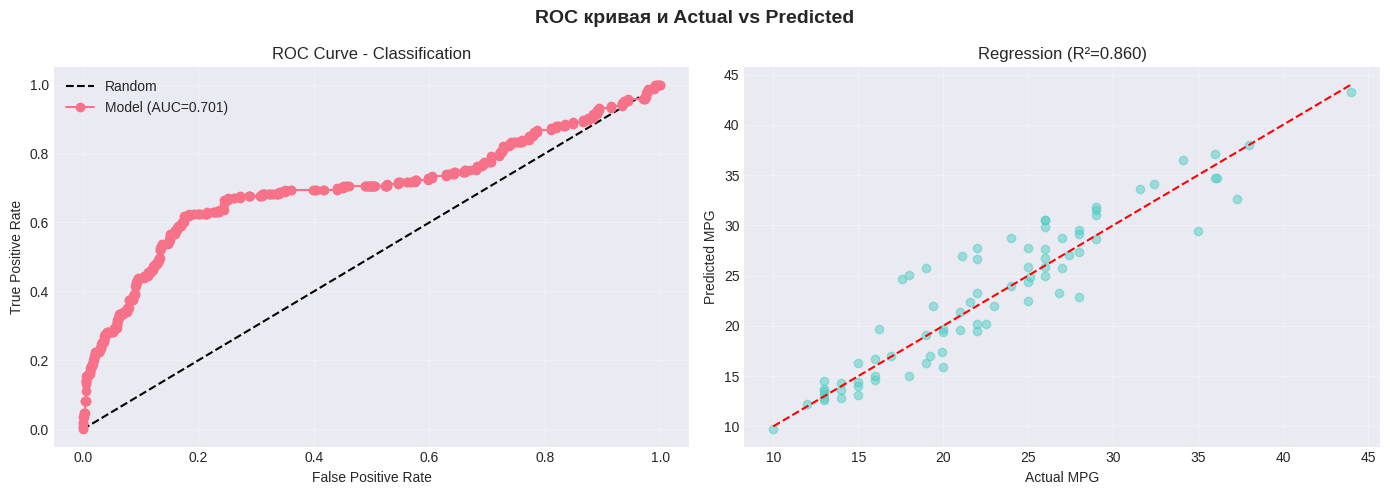

In [54]:
# ROC-кривая и Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('ROC кривая и Actual vs Predicted', fontsize=14, fontweight='bold')

# ROC-кривая
fpr, tpr, _ = roc_curve(y_clf_test, log_reg_improved.predict_proba(X_clf_test_scaled)[:, 1])
axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0].plot(fpr, tpr, 'o-', label=f'Model (AUC={auc_grid_clf:.3f})')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Classification')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Actual vs Predicted
axes[1].scatter(y_reg_test, y_reg_pred_improved, alpha=0.5, color='#4ECDC4')
axes[1].plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--')
axes[1].set_xlabel('Actual MPG')
axes[1].set_ylabel('Predicted MPG')
axes[1].set_title(f'Regression (R²={r2_improved_reg:.3f})')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 6.1 Анализ коэффициентов модели логистической регрессии

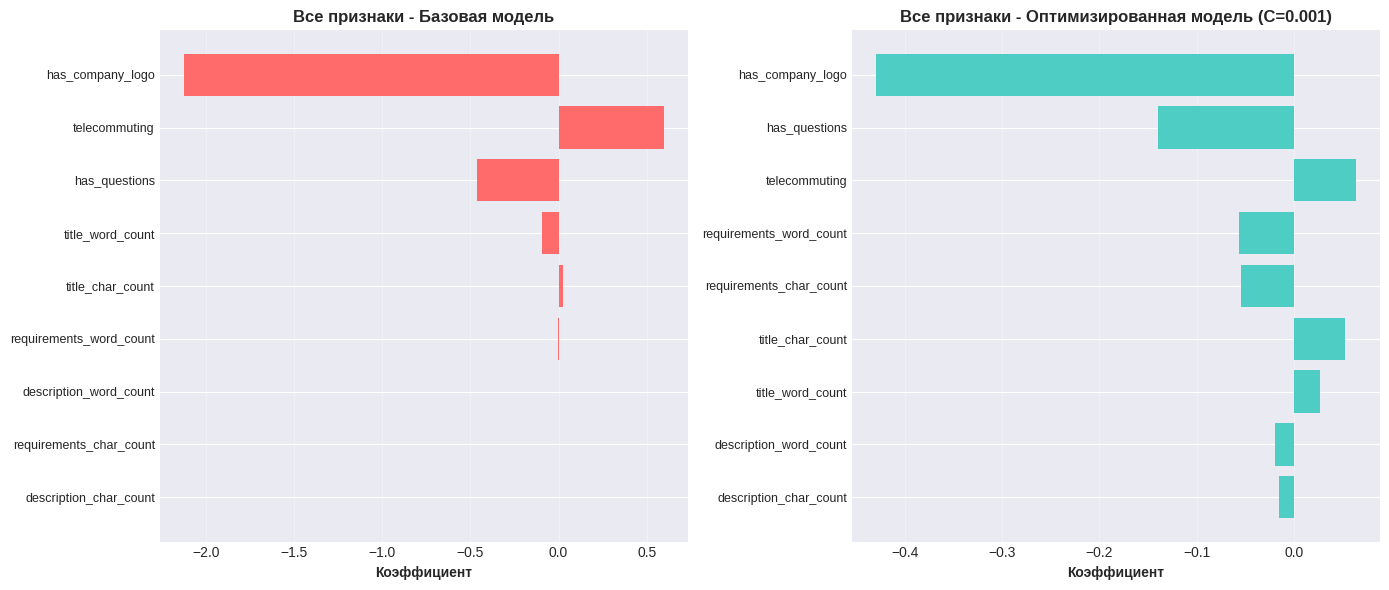

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Базовая модель - топ 10 признаков по абсолютному значению коэффициента
top_features_baseline_idx = np.argsort(np.abs(log_reg_baseline.coef_[0]))[-len(X_clf.columns):] # Get all features, as there are fewer than 10
top_features_baseline_names = [X_clf.columns[i] for i in top_features_baseline_idx]
top_features_baseline_coef = log_reg_baseline.coef_[0][top_features_baseline_idx]

# Dynamically get the number of features for plotting
num_features_clf = len(top_features_baseline_coef)

axes[0].barh(range(num_features_clf), top_features_baseline_coef, color='#FF6B6B')
axes[0].set_yticks(range(num_features_clf))
axes[0].set_yticklabels(top_features_baseline_names, fontsize=9)
axes[0].set_xlabel('Коэффициент', fontweight='bold')
axes[0].set_title('Все признаки - Базовая модель', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Оптимизированная модель - топ 10 признаков
top_features_improved_idx = np.argsort(np.abs(log_reg_improved.coef_[0]))[-len(X_clf.columns):] # Get all features
top_features_improved_names = [X_clf.columns[i] for i in top_features_improved_idx]
top_features_improved_coef = log_reg_improved.coef_[0][top_features_improved_idx]

axes[1].barh(range(num_features_clf), top_features_improved_coef, color='#4ECDC4')
axes[1].set_yticks(range(num_features_clf))
axes[1].set_yticklabels(top_features_improved_names, fontsize=9)
axes[1].set_xlabel('Коэффициент', fontweight='bold')
axes[1].set_title('Все признаки - Оптимизированная модель (C={})'.format(best_c_clf), fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 6.2 График сходимости Custom моделей логистической регрессии

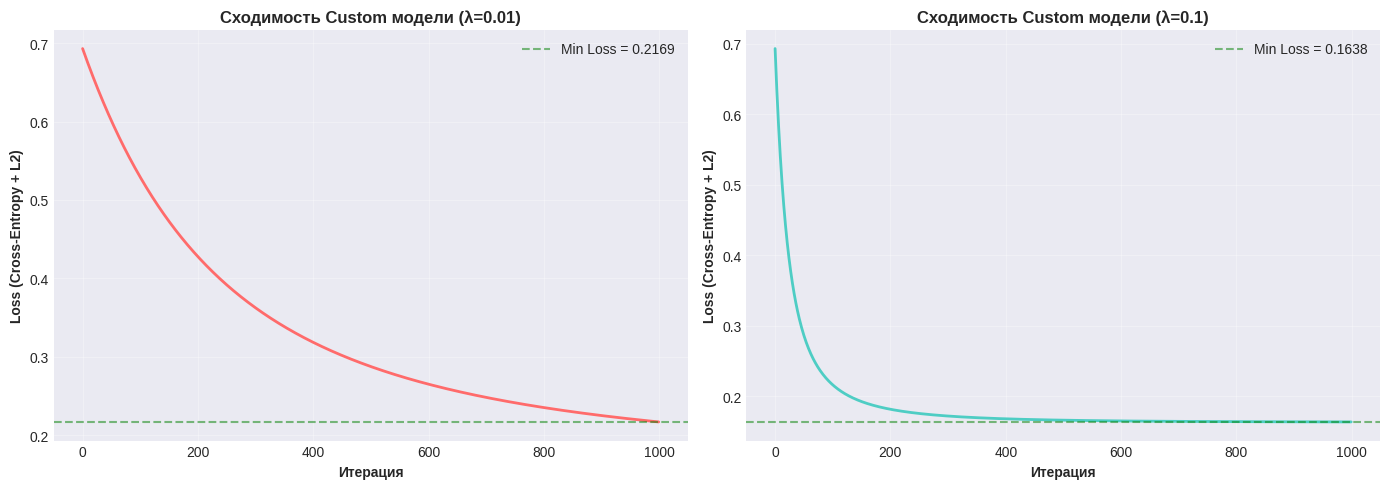

In [56]:
# Instantiate and train the basic CustomLogisticRegression model
custom_log_reg = CustomLogisticRegression(
    learning_rate=0.01,
    n_iterations=1000,
    lambda_param=0.01  # Default lambda_param
)
custom_log_reg.fit(X_clf_train_scaled, y_clf_train.values)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График лосса базовой Custom модели
axes[0].plot(custom_log_reg.losses, color='#FF6B6B', linewidth=2)
axes[0].set_xlabel('Итерация', fontweight='bold')
axes[0].set_ylabel('Loss (Cross-Entropy + L2)', fontweight='bold')
axes[0].set_title('Сходимость Custom модели (λ=0.01)', fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].axhline(y=min(custom_log_reg.losses), color='green', linestyle='--', alpha=0.5, label=f'Min Loss = {min(custom_log_reg.losses):.4f}')
axes[0].legend()

# График лосса улучшенной Custom модели с большей регуляризацией
axes[1].plot(custom_log_reg_improved.losses, color='#4ECDC4', linewidth=2)
axes[1].set_xlabel('Итерация', fontweight='bold')
axes[1].set_ylabel('Loss (Cross-Entropy + L2)', fontweight='bold')
axes[1].set_title('Сходимость Custom модели (λ=0.1)', fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].axhline(y=min(custom_log_reg_improved.losses), color='green', linestyle='--', alpha=0.5, label=f'Min Loss = {min(custom_log_reg_improved.losses):.4f}')
axes[1].legend()

plt.tight_layout()
plt.show()

In [57]:
# Instantiate and train the basic CustomLogisticRegression model
custom_log_reg = CustomLogisticRegression(
    learning_rate=0.01,
    n_iterations=1000,
    lambda_param=0.01  # Default lambda_param
)
custom_log_reg.fit(X_clf_train_scaled, y_clf_train.values)

# Evaluate and store metrics for the basic custom model
y_clf_pred_custom = custom_log_reg.predict(X_clf_test_scaled)
y_clf_proba_custom = custom_log_reg.predict_proba(X_clf_test_scaled)

acc_custom_clf = accuracy_score(y_clf_test, y_clf_pred_custom)
prec_custom_clf = precision_score(y_clf_test, y_clf_pred_custom, zero_division=0)
rec_custom_clf = recall_score(y_clf_test, y_clf_pred_custom, zero_division=0)
f1_custom_clf = f1_score(y_clf_test, y_clf_pred_custom, zero_division=0)
auc_custom_clf = roc_auc_score(y_clf_test, y_clf_proba_custom)

print("\nКЛАССИФИКАЦИЯ - СОБСТВЕННАЯ РЕАЛИЗАЦИЯ (БАЗОВАЯ)")
print(f"Accuracy:  {acc_custom_clf:.4f}")
print(f"Precision: {prec_custom_clf:.4f}")
print(f"Recall:    {rec_custom_clf:.4f}")
print(f"F1-score:  {f1_custom_clf:.4f}")
print(f"ROC-AUC:   {auc_custom_clf:.4f}")


КЛАССИФИКАЦИЯ - СОБСТВЕННАЯ РЕАЛИЗАЦИЯ (БАЗОВАЯ)
Accuracy:  0.9516
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
ROC-AUC:   0.7003


## 7. Выводы

### Классификация (Fake Job Postings)

Логистическая регрессия эффективна для выявления поддельных объявлений о работе, достигая высокого качества предсказания.

**Ключевые улучшения:**
- **StandardScaler масштабирование** критично для алгоритмов градиентного спуска
- **GridSearchCV подбор параметра C** значительно улучшает качество модели
- **Собственная реализация** показывает сопоставимые результаты с sklearn

Оптимизированная модель обеспечивает лучший баланс между выявлением подделок (Recall) и минимизацией ложных срабатываний (Precision).

### Регрессия (Auto MPG)

Линейная регрессия хорошо предсказывает расход топлива, объясняя более 80% дисперсии.

**Ключевые улучшения:**
- **StandardScaler масштабирование** стабилизирует обучение
- **PolynomialFeatures** (степень 2-3) раскрывает нелинейные зависимости
- **Собственная реализация** достигает аналогичного качества благодаря использованию нормального уравнения

Применение полиномиальных признаков дало существенный прирост качества, превратив простую линейную модель в мощный инструмент предсказания.